In [259]:
# max/min/mean/median/variance of each time series values
# contamination, max anom length, min anom length, average anom length, anom counts
# max/min/mean/median/variance of each time series anomaly values

# autocorrelation ?
# histogram of training set vs. test set values

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple
from enum import Enum

FIGSIZE = (10, 3)

DATASET_PATH = Path("data/raw/public/univariate/KDD-TSAD")
DATASET_NAME = DATASET_PATH.name

test_files = sorted(DATASET_PATH.glob('*.test.csv'))
train_files = sorted(DATASET_PATH.glob('*.train.csv'))

if len(train_files) != 0:
    HAS_TRAINING_EXAMPLES = 1
    assert len(test_files) == len(train_files), "Different number of training files and test files!"
else:
    HAS_TRAINING_EXAMPLES = 0

test_train_pairs = list(zip(test_files, train_files))

In [260]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

def reject_outliers(values: np.ndarray, m = 3) -> np.ndarray:
    d = np.abs(values - np.median(values))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return values[s < m]

In [261]:
class Validity(Enum):
    VALID = 1
    TEST_HAS_NAN = 2
    TRAIN_HAS_NAN = 3
    TEST_HAS_NO_ANOMALIES = 4
    TRAIN_HAS_ANOMALIES = 5
    TEST_TRAIN_EQUAL = 6
    TEST_ALL_ZEROS = 7
    TRAIN_ALL_ZEROS = 8

def get_sanity_check(test_values: np.ndarray, test_labels: np.ndarray, train_values: np.ndarray = None, train_labels: np.ndarray = None) -> Validity:
    if np.isnan(np.sum(test_values)): return Validity.TEST_HAS_NAN
    if np.sum(test_labels) == 0: return Validity.TEST_HAS_NO_ANOMALIES
    if not np.any(test_values): return Validity.TEST_ALL_ZEROS

    if train_values is not None or train_labels is not None:
        if np.isnan(np.sum(train_values)): return Validity.TRAIN_HAS_NAN
        if np.sum(train_labels) != 0: return Validity.TRAIN_HAS_ANOMALIES
        if np.array_equal(test_values, train_values): return Validity.TEST_TRAIN_EQUAL
        if not np.any(train_values): return Validity.TRAIN_ALL_ZEROS

    return Validity.VALID

def get_basic_stats(values: np.ndarray, prefix: str) -> dict:
    stats = {
        "len": len(values),
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "std": np.std(values),
    }
    return {prefix + str(k): v for k, v in stats.items()}

def get_anomaly_info(labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    label_diffs = np.diff(np.r_[0, labels, 0])
    anom_starts = np.where(label_diffs == 1)[0]
    anom_ends = np.where(label_diffs == -1)[0]
    anom_lens = anom_ends - anom_starts
    anom_indices = np.concatenate([np.arange(start, end) for start, end in zip(anom_starts, anom_ends)])
    return anom_indices.astype(np.int64), anom_lens

def load_data(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    timestamp, values, labels = np.hsplit(pd.read_csv(path).values, 3)
    return values.astype(dtype=np.float64).flatten(), labels.astype(dtype=np.float64).flatten()

def get_metadata(test_path: Path, train_path: Path = None) -> dict:
    test_values, test_labels = load_data(test_path)

    if train_path:
        train_values, train_labels = load_data(train_path)
        sanity_check = get_sanity_check(test_values, test_labels, train_values=train_values, train_labels=train_labels)
        train_stats = get_basic_stats(train_values, 'train_')
    else:
        sanity_check = get_sanity_check(test_values, test_labels)

    stats = {
        "test_name": test_path.name,
        "sanity_check": sanity_check,
    }
    if sanity_check != Validity.VALID:
        return stats

    anom_indices, anom_lens = get_anomaly_info(test_labels)
    test_anom_values = test_values[anom_indices]
    
    stats |= get_basic_stats(test_values, 'test_') |\
    get_basic_stats(test_anom_values, 'test_anom_') |\
    {
        "test_anom_contamination": np.sum(test_labels)/len(test_labels),
        "test_anom_count": len(anom_lens),
        "test_anom_max_len": max(anom_lens),
        "test_anom_min_len": min(anom_lens),
        "test_anom_mean_len": np.mean(anom_lens),
    }

    if train_path:
        return stats | train_stats
    else:
        return stats

In [262]:
stats_list = []

if HAS_TRAINING_EXAMPLES:
    for test_path, train_path in test_train_pairs:
        stats_list.append(list(get_metadata(test_path, train_path=train_path).values()))

    stats_df = pd.DataFrame(stats_list)
    stats_df.columns = get_metadata(*test_train_pairs[0]).keys()
else:
    for test_path in test_files:
        stats_list.append(list(get_metadata(test_path, train_path=None).values()))
    
    stats_df = pd.DataFrame(stats_list)
    stats_df.columns = get_metadata(test_files[0], train_path=None).keys()

print(stats_df.columns)
display(stats_df)

Index(['test_name', 'sanity_check', 'test_len', 'test_min', 'test_max',
       'test_mean', 'test_std', 'test_anom_len', 'test_anom_min',
       'test_anom_max', 'test_anom_mean', 'test_anom_std',
       'test_anom_contamination', 'test_anom_count', 'test_anom_max_len',
       'test_anom_min_len', 'test_anom_mean_len', 'train_len', 'train_min',
       'train_max', 'train_mean', 'train_std'],
      dtype='object')


,test_name,sanity_check,test_len,test_min,test_max,test_mean,test_std,test_anom_len,test_anom_min,test_anom_max,...,test_anom_contamination,test_anom_count,test_anom_max_len,test_anom_min_len,test_anom_mean_len,train_len,train_min,train_max,train_mean,train_std
0,001_UCR_Anomaly_DISTORTED1sddb40.test.csv,Validity.VALID,79795.0,-1028.681300,912.367080,-27.144590,175.477113,620.0,-673.769000,154.019820,...,0.007770,1.0,620.0,620.0,620.0,35000.0,-940.826000,836.231690,-24.119963,176.402622
1,002_UCR_Anomaly_DISTORTED2sddb40.test.csv,Validity.VALID,80001.0,-1039.978200,892.872280,-25.141412,173.017127,300.0,-61.150842,45.273220,...,0.003750,1.0,300.0,300.0,300.0,35000.0,-948.031490,815.811500,-23.345324,176.456935
2,003_UCR_Anomaly_DISTORTED3sddb40.test.csv,Validity.VALID,80000.0,-1059.006000,896.051350,-24.828451,172.601391,300.0,-743.427500,286.905570,...,0.003750,1.0,300.0,300.0,300.0,35000.0,-924.507970,842.170170,-23.590519,175.551478
3,004_UCR_Anomaly_DISTORTEDBIDMC1.test.csv,Validity.VALID,11000.0,-14535.311000,32306.480000,1130.949099,9314.795642,200.0,-11544.677000,32306.480000,...,0.018182,1.0,200.0,200.0,200.0,2500.0,-14535.311000,23796.450000,1415.551032,9187.451289
4,005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature...,Validity.VALID,8184.0,2.214464,34.463007,15.196513,5.659729,1.0,18.639500,18.639500,...,0.000122,1.0,1.0,1.0,1.0,4000.0,2.214464,34.463007,14.260735,5.592120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246_UCR_Anomaly_tilt12755mtable.test.csv,Validity.VALID,299867.0,-4.000000,8388.000000,5041.727730,889.322257,270.0,4902.666700,7352.000000,...,0.000900,1.0,270.0,270.0,270.0,100211.0,0.000000,8388.000000,4860.144495,821.951491
246,247_UCR_Anomaly_tilt12755mtable.test.csv,Validity.VALID,200000.0,0.000000,8388.000000,4978.535763,876.775416,80.0,3769.333300,4790.666700,...,0.000400,1.0,80.0,80.0,80.0,50211.0,0.000000,7724.000000,4836.313955,902.376867
247,248_UCR_Anomaly_weallwalk.test.csv,Validity.VALID,8432.0,-2.058551,0.779785,-1.185222,0.398717,5.0,-1.900000,-1.900000,...,0.000593,1.0,5.0,5.0,5.0,2000.0,-2.000000,0.779785,-1.187176,0.481387
248,249_UCR_Anomaly_weallwalk.test.csv,Validity.VALID,10524.0,-2.055791,0.779785,-1.185866,0.392666,30.0,-1.922218,-0.339849,...,0.002851,1.0,30.0,30.0,30.0,2753.0,-2.055043,0.779785,-1.182231,0.446399


Number of invalid examples: 4


,test_name,sanity_check,test_len,test_min,test_max,test_mean,test_std,test_anom_len,test_anom_min,test_anom_max,...,test_anom_contamination,test_anom_count,test_anom_max_len,test_anom_min_len,test_anom_mean_len,train_len,train_min,train_max,train_mean,train_std
78,079_UCR_Anomaly_DISTORTEDresperation2.test.csv,Validity.TEST_HAS_NO_ANOMALIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,108_UCR_Anomaly_NOISEresperation2.test.csv,Validity.TEST_HAS_NO_ANOMALIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,187_UCR_Anomaly_resperation2.test.csv,Validity.TEST_HAS_NO_ANOMALIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,203_UCR_Anomaly_CHARISfive.test.csv,Validity.TRAIN_HAS_ANOMALIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


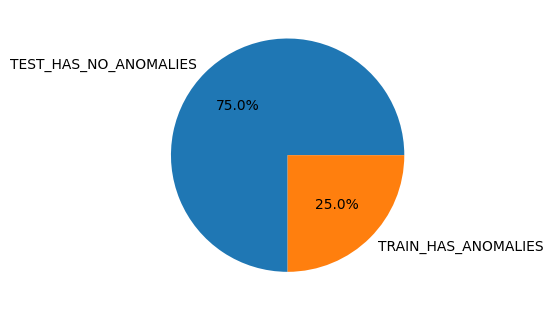

In [263]:
# find invalid examples
invalid_df = stats_df[stats_df['sanity_check'] != Validity.VALID]
if invalid_df.shape[0] != 0:
    print(f"Number of invalid examples: {invalid_df.shape[0]}")
    display(invalid_df)
    fig, axs = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')
    unique, counts = np.unique([el.value for el in invalid_df['sanity_check']], return_counts=True)
    labels = [Validity(v).name for v in unique]
    axs.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.show()

# filter invalid examples
stats_df = stats_df[stats_df['sanity_check'] == Validity.VALID]

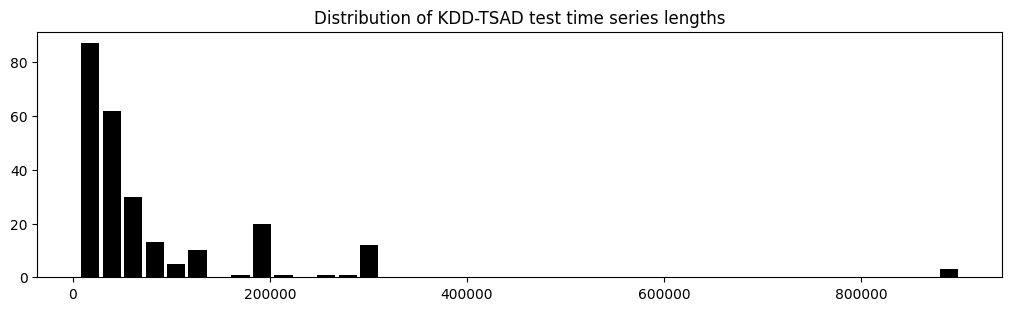

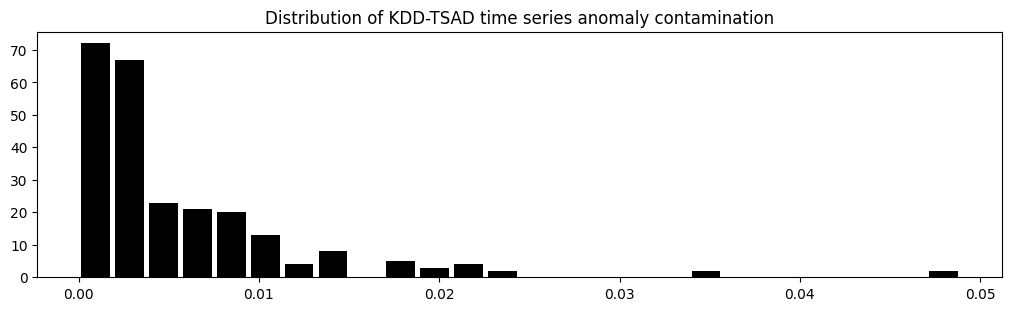

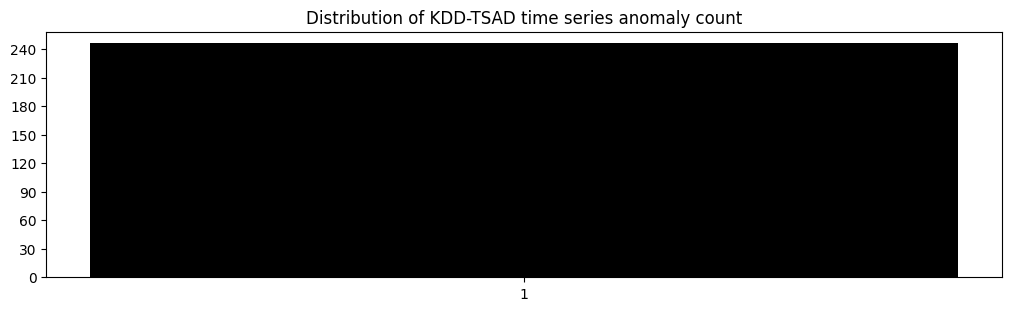

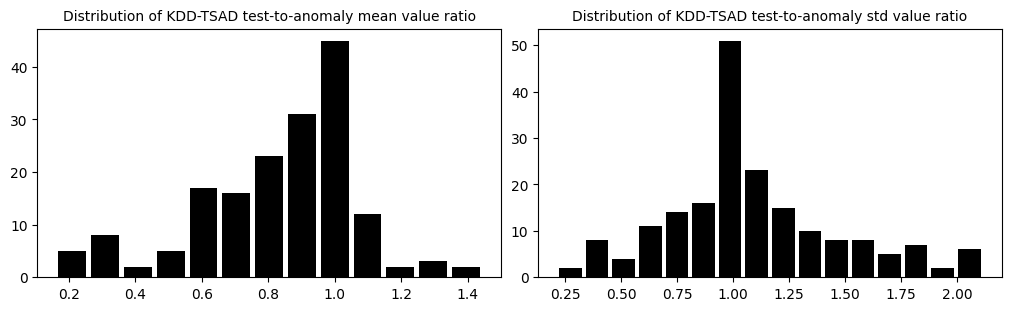

In [264]:
# print(stats_df['test_len'].head(5))
fig, axs = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')
axs.set_title(f"Distribution of {DATASET_NAME} test time series lengths")
axs.hist(stats_df['test_len'], bins='auto', color='black', rwidth=0.85)
plt.show()

# print(stats_df['test_anom_contamination'].head(5))
fig, axs = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')
axs.set_title(f"Distribution of {DATASET_NAME} time series anomaly contamination")
axs.hist(stats_df['test_anom_contamination'], bins='auto', color='black', rwidth=0.85)
plt.show()

from matplotlib.ticker import MaxNLocator

# print(stats_df['test_anom_count'].head(5))
fig, axs = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')
unique, counts = np.unique(stats_df['test_anom_count'], return_counts=True)
axs.set_title(f"Distribution of {DATASET_NAME} time series anomaly count")
axs.bar(np.arange(1, unique.size+1).astype(str), counts, width=0.8, color='black')
axs.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=FIGSIZE, layout='constrained')
axs[0].set_title(f"Distribution of {DATASET_NAME} test-to-anomaly mean value ratio", fontsize=10)
axs[0].hist(reject_outliers(stats_df['test_mean']/stats_df['test_anom_mean']), bins='auto', color='black', rwidth=0.85)

axs[1].set_title(f"Distribution of {DATASET_NAME} test-to-anomaly std value ratio", fontsize=10)
axs[1].hist(reject_outliers(stats_df['test_std']/stats_df['test_anom_std']), bins='auto', color='black', rwidth=0.85)
plt.show()

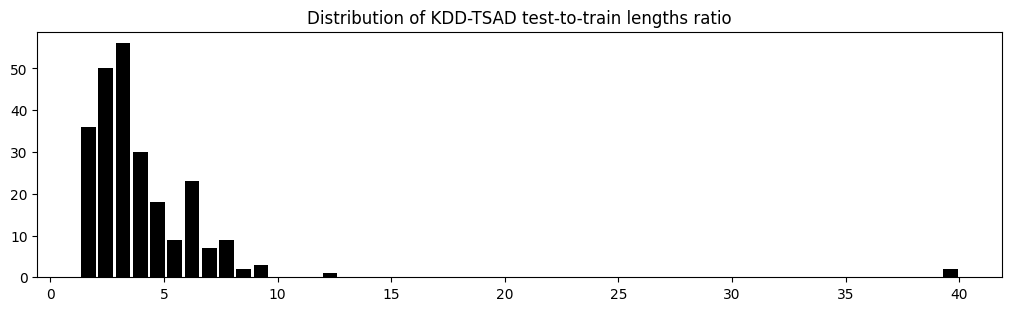

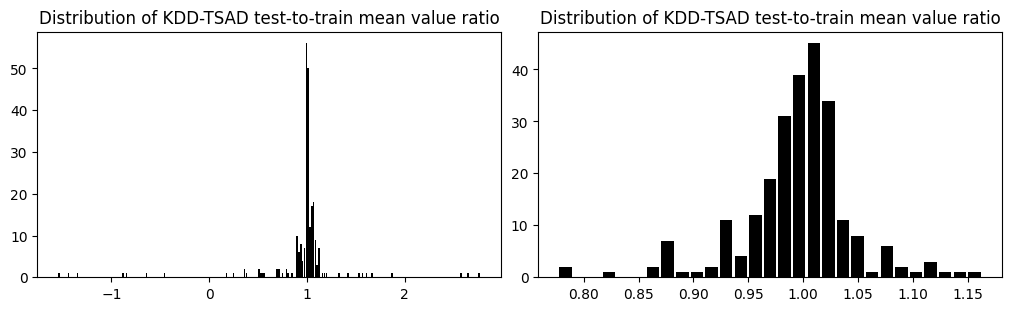

In [265]:
if HAS_TRAINING_EXAMPLES != 1:
    raise StopExecution

fig, axs = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')
axs.set_title(f"Distribution of {DATASET_NAME} test-to-train lengths ratio")
axs.hist(stats_df['test_len']/stats_df['train_len'], bins='auto', color='black', rwidth=0.85)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=FIGSIZE, layout='constrained')
axs[0].set_title(f"Distribution of {DATASET_NAME} test-to-train mean value ratio")
axs[0].hist(stats_df['test_mean']/stats_df['train_mean'], bins='auto', color='black', rwidth=0.85)

# errors when std is 0 i.e. time series is flat
try:
    axs[1].set_title(f"Distribution of {DATASET_NAME} test-to-train mean value ratio")
    axs[1].hist(stats_df['test_std']/stats_df['train_std'], bins='auto', color='black', rwidth=0.85)
except Exception:
    pass

plt.show()

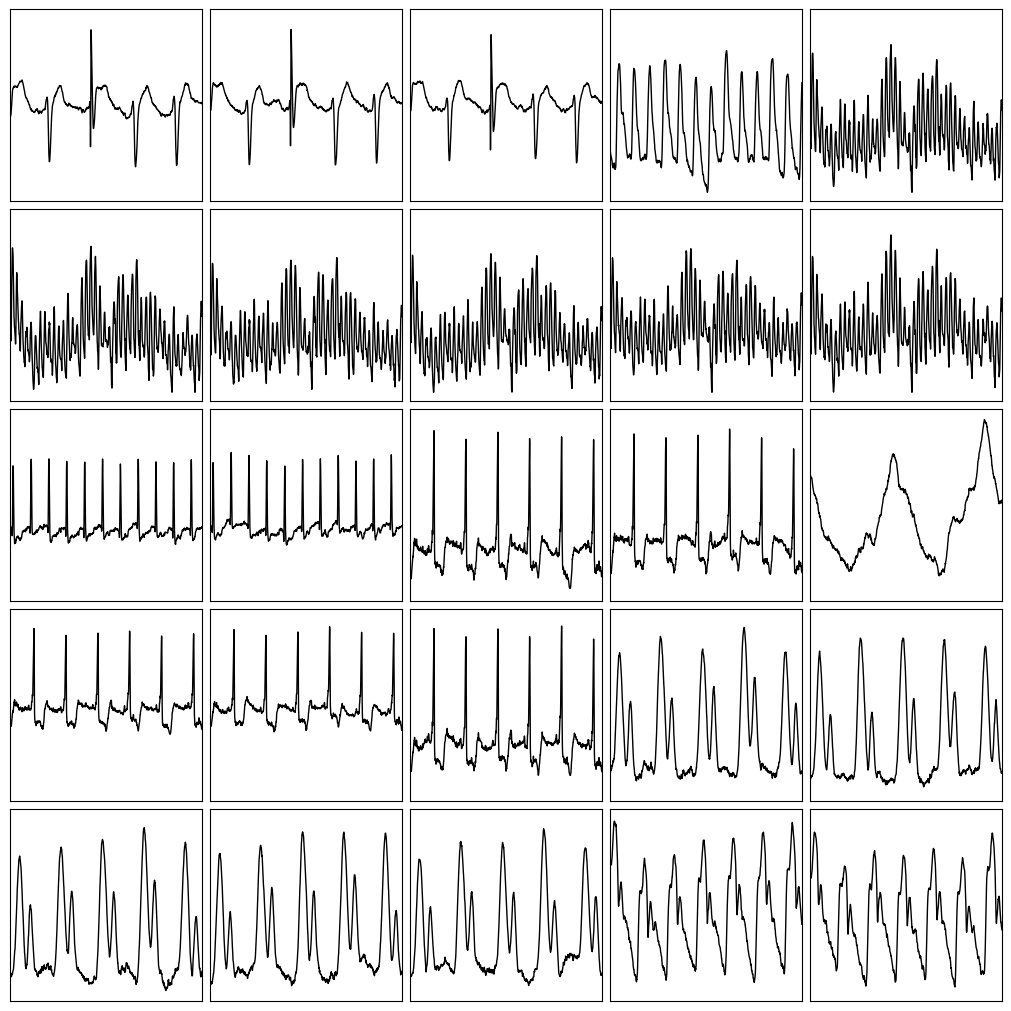

In [266]:
# t-sne embeddings of algorithm auc-roc on each dataset
# want to quantify the diversity of each datasets anomalies

fig, axs = plt.subplots(5, 5, figsize=(10, 10), layout='constrained')

axs = axs.flatten()
for ax, test_path in zip(axs, test_files):
    test_values, test_labels = load_data(test_path)

    ax.plot(test_values, lw=1, color='black')
    ax.set_xlim([0, 1000])
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs:
    # Check if the subplot is empty
    if not ax.has_data():
        fig.delaxes(ax)

plt.show()

12000


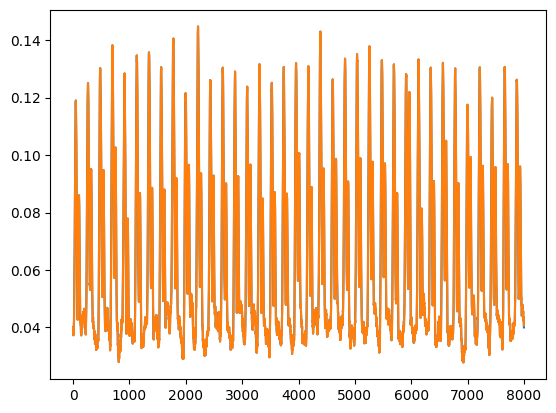

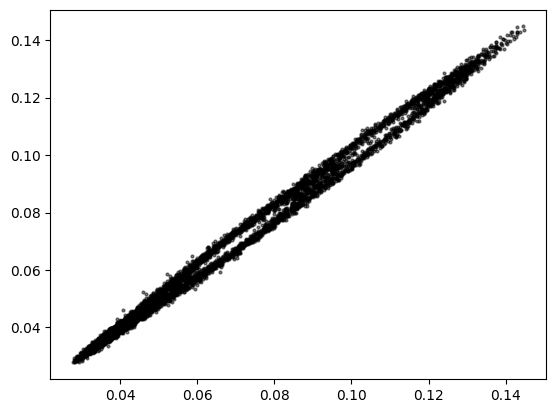

In [450]:
from statsmodels.tsa.stattools import pacf

def acf(x, nlags=None):
    # length = int(0.8*len(x))\
    if nlags is None:
        nlags = min(int(10*np.log10(len(x))), len(x)//(2 - 1))
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, nlags)])

# plt.plot(acf(test_values, nlags=50), lw=1, color='black')
# plt.show()

test_values, test_labels = load_data(test_files[20])

# test_values = np.random.normal(size=10_000)

# pacf_values = pacf(test_values, nlags=5000)
# inds = np.argpartition(pacf_values, -10)[-10:]
# max_inds = inds[np.argsort(pacf_values[inds])][::-1]

# plt.plot(pacf_values, lw=1, color='black')
# plt.show()

# i = 1
# print(max_inds[i])

# # max_inds[i] = 650

print(len(test_values))

# v = max_inds[2]
v = 1
x = test_values[v:v + 8000]
y = test_values[:8000]

plt.plot(x)
plt.plot(y)
plt.show()

plt.scatter(x=x, y=y, s=4, color='black', alpha=0.5)
plt.show()

# # plt.plot(test_values[max_inds[1]:max_inds[1] + 1000])
# # plt.plot(test_values[:1000])
# # plt.show()

In [391]:
print(max_inds)

[3196 2464 2922 4719 3140 1559 1233  562 1369 2406]


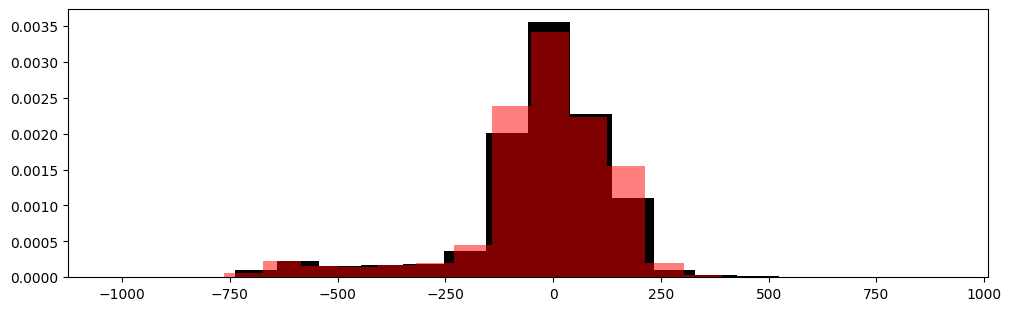

In [268]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')

test_path, train_path = test_train_pairs[0]

test_values, test_labels = load_data(test_path)
train_values, train_labels = load_data(train_path)

density, bins = np.histogram(test_values, bins=20, density=True)
# indices = np.digitize(density, bins)
ax.hist(bins[:-1], bins, weights=density, rwidth=1, color='black')

density, bins = np.histogram(train_values, bins=20, density=True)
# indices = np.digitize(density, bins)
ax.hist(bins[:-1], bins, weights=density, rwidth=1, color='red', alpha=0.5)

plt.show()

data/raw/public/univariate/KDD-TSAD/024_UCR_Anomaly_DISTORTEDInternalBleeding10.test.csv
data/raw/public/univariate/KDD-TSAD/024_UCR_Anomaly_DISTORTEDInternalBleeding10.train.csv


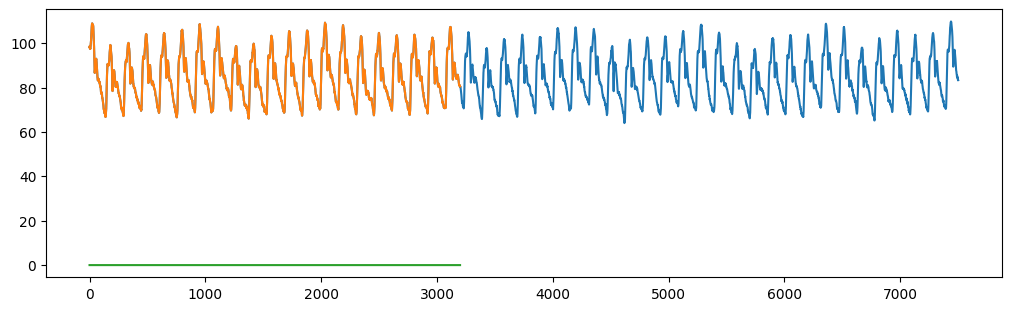

In [269]:
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, layout='constrained')

test_path, train_path = test_train_pairs[23]

print(test_path)
print(train_path)

test_values, test_labels = load_data(test_path)
train_values, train_labels = load_data(train_path)

min_len = min(len(test_values), len(train_values))
# assert np.array_equal(test_values[:min_len], train_values[:min_len])

plt.plot(test_values)
plt.plot(train_values)
plt.plot((test_values[:min_len] - train_values[:min_len])**2)
plt.show()